In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import os

import itertools
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from utils import implot, load_data, create_cartesian_metrics
from experiences.experience import ExperienceRealization

plt.style.use({'figure.facecolor':'white'})
def product_dict(**kwargs):
    for keys in kwargs.keys():
        if type(kwargs[keys]) not in [list, tuple, np.ndarray]:
            kwargs[keys] = [kwargs[keys]]
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))


/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
  warnings.warn("pynfft python package has not been found. If needed use "
/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "


In [3]:
fourier = [1,2]

regs = [
    {
        'class': 'GroupLASSO',
        'kwargs': {'weights': [5e-4]},
        'cst_kwargs': {}
    },
    {
        'class': 'IdentityProx',
        'cst_kwargs': {},
        'kwargs': {},
    }
]

algo = [
    {
        'opt': 'condatvu',
        'kwargs': {},
    },
    # {
    #     'opt': 'pogm',
    #     'kwargs': {}
    # },
    {
        'opt': 'vanilla',
        'kwargs': {
            'eta': [0.1, 0.5, 1.0]
        }
    },
    # {
    #     'opt': 'adagrad',
    #     'kwargs': {
    #         'eta': [0.1, 0.5, 1.0]
    #     }
    # },
    # {
    {
        'opt': 'rmsprop',
        'kwargs': {
            'eta': [0.001, 0.01, 0.1],
            'gamma': [0.0],
        }
    },
    {
        'opt': 'momentum',
        'kwargs': {
            'eta': np.linspace(0.2, 1.0, 5),
            'beta':np.linspace(0.2, 1.0, 5),
        }
    },
  {
        'opt': 'adam',
        'kwargs': {
            'eta': [0.0001,0.001,],
            'beta': [0.001,],
            'gamma': [0.001],

        }
    },
]
ExperienceRealization.objects.flush()
ExperienceRealization.save_folder = os.path.join(os.getcwd(), 'results')

for f_config in fourier:
    for reg_config in regs:
        for reg_param in product_dict(**reg_config['kwargs']):
            for alg_config in algo:
                for alg_param in product_dict(**alg_config['kwargs']):
                    ExperienceRealization.objects.create(**{'online': f_config,
                                  'linear_cls': 'WaveletN',
                                  'reg_cls': reg_config['class'],
                                  'reg_kwargs': reg_param,
                                  'opt': alg_config['opt'],
                                  'alg_kwargs': alg_param,})

# Momentum
## GroupLASSO Regularisation

In [4]:
condat_set2 = ExperienceRealization.objects.filter(mode='and',
                                                   opt='momentum',
                                                   online=1,
                                                   reg_cls = 'GroupLASSO',
                                                   reg_kwargs__weights=1e-4,
                                                   results__data_res_off__max__le=1e-3)
condat_set2 =condat_set2.filter(results__data_res_off__median__le=5e-5)
condat_set2.filter_plot('data_res_off','psnr');

<Figure size 432x288 with 0 Axes>

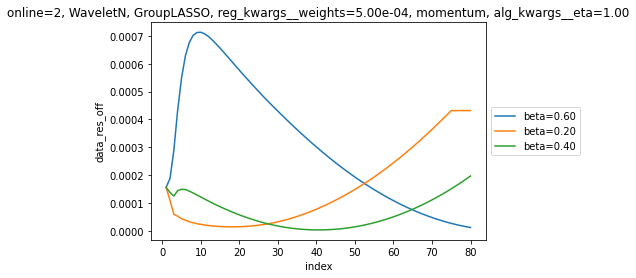

<Figure size 432x288 with 0 Axes>

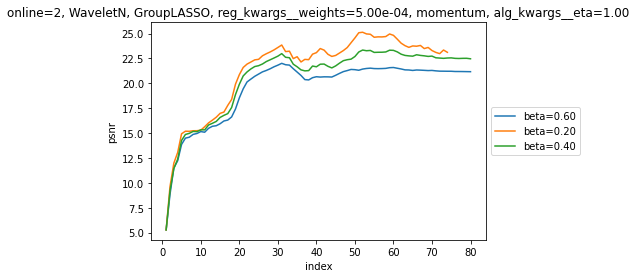

<Figure size 432x288 with 0 Axes>

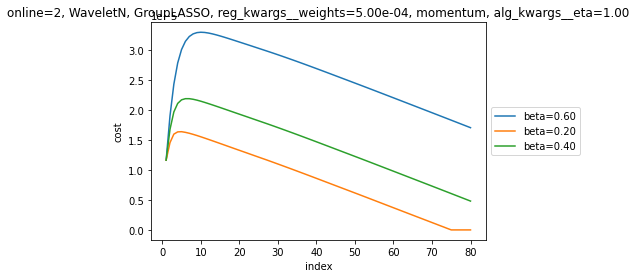

In [5]:
condat_set2 = ExperienceRealization.objects.filter(mode='and',
                                                   opt='momentum',
                                                   online=2,
                                                   reg_kwargs__weights=5e-4,
                                                   reg_cls = 'GroupLASSO',
                                                   alg_kwargs__eta=1.0,
                                                   results__psnr__max__ge=22)
condat_set2.filter_plot('data_res_off','psnr','cost', results__data_res_off__max__le=1e-3);

## Identity Prox

<Figure size 432x288 with 0 Axes>

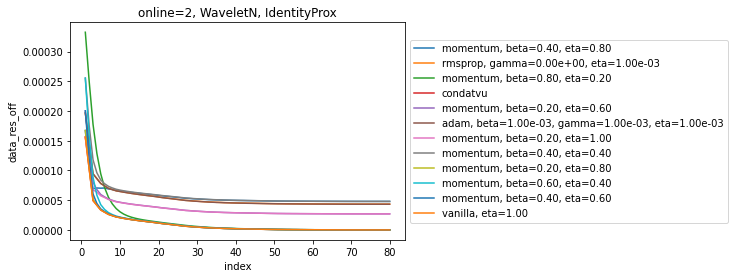

<Figure size 432x288 with 0 Axes>

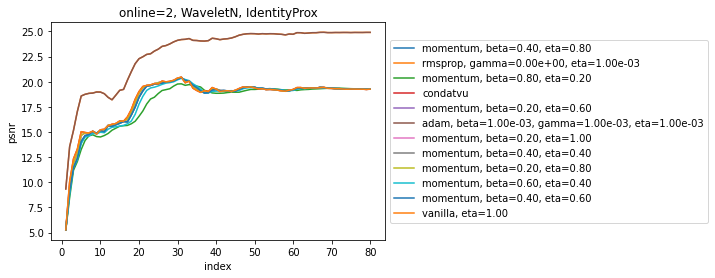

In [6]:
condat_set2 = ExperienceRealization.objects.filter(mode='and',
                                                   online=2,
                                                   reg_cls = 'IdentityProx',
                                                   results__data_res_off__max__le=1e-3).filter(
                                                   results__data_res_off__median__le=5e-5)
condat_set2.filter_plot('data_res_off','psnr');

# RMSprop
## GroupLASSO Regularisation


<Figure size 432x288 with 0 Axes>

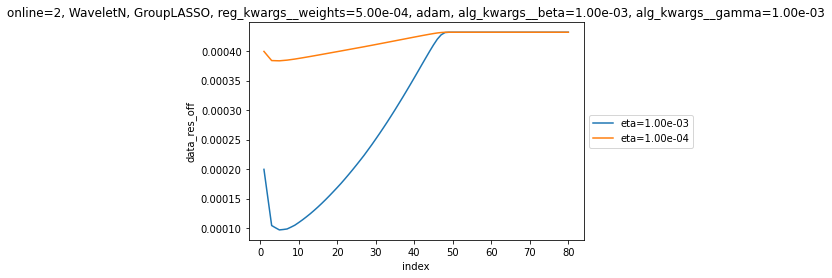

<Figure size 432x288 with 0 Axes>

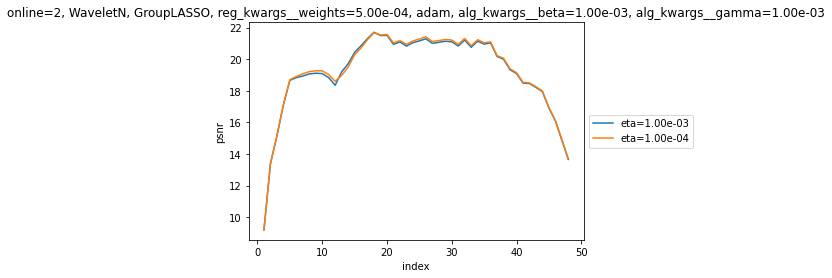

<Figure size 432x288 with 0 Axes>

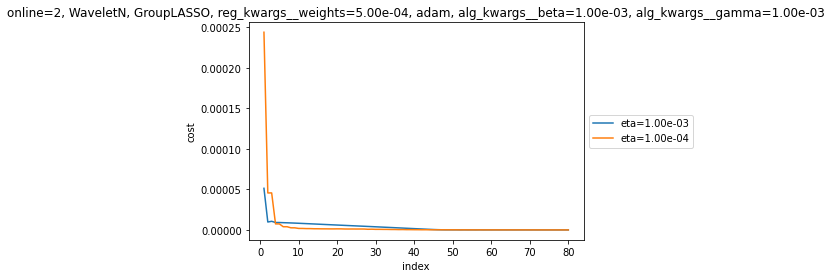

In [7]:
condat_set2 = ExperienceRealization.objects.filter(mode='loose_and',
                                                   online=2,
                                                   opt='adam',
                                                   reg_cls='GroupLASSO',
                                                   results__data_res_off__max__le=10,
                                                   )
condat_set2.filter_plot('data_res_off','psnr','cost',results__psnr__max__ge=10);

## Identity Prox

<Figure size 432x288 with 0 Axes>

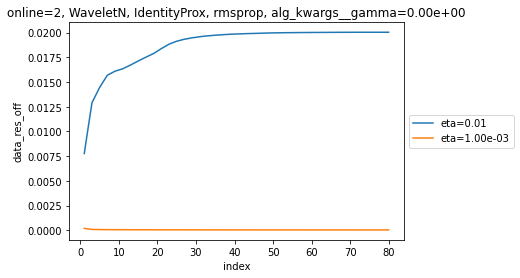

<Figure size 432x288 with 0 Axes>

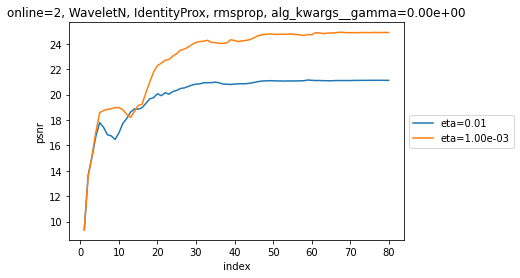

In [8]:
condat_set2 = ExperienceRealization.objects.filter(mode='loose_and',
                                                   online=2,
                                                   opt='rmsprop',
                                                   reg_cls = 'IdentityProx',
                                                   )
condat_set2.filter_plot('data_res_off','psnr',results__psnr__max__ge=18);


# Basic reconstruction

In [9]:
from mri.operators import FFT, WaveletN, OWL
from modopt.opt.proximity import GroupLASSO, IdentityProx

from online.generators.column import Column2DKspaceGenerator, DataOnlyKspaceGenerator
from online.reconstructors.reconstructor import OnlineReconstructor
from online.operators.fourier import ColumnFFT
from online.metrics import crop_center_square, ssos

In [10]:
DATA_DIR = "data/"
N_JOBS = 1

full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR,1)
# use mono-coil data
full_k = sp.fft.ifftshift(sp.fft.fft2(real_img,s=(320,320),norm="ortho"))
final_mask = crop_center_square(final_mask)
final_k = full_k * final_mask


line_kspace_gen = DataOnlyKspaceGenerator(final_k, mask_loc)
K_DIM = line_kspace_gen.shape[-2:]
N_COILS = line_kspace_gen.shape[0] if full_k.ndim == 3 else 1

line_fourier_op = ColumnFFT(shape=K_DIM, line_index = 0, n_coils=N_COILS, n_jobs=N_JOBS)

linear_op = WaveletN("sym8", nb_scale=4, n_coils=N_COILS, n_jobs=N_JOBS)
# initialisation of wavelet transform
linear_op.op(np.zeros_like(final_k))

# Regularizer definition
GL_op = GroupLASSO(weights = 5e-4)
OWL_op = OWL(alpha=1e-05,
             beta=1e-12,
             bands_shape=linear_op.coeffs_shape,
             mode='band_based',
             n_coils=N_COILS,
             n_jobs=N_JOBS)
cost_op_kwargs = {'cost_interval': 1}


(16, 640, 320) complex128
(320, 320) float32
file_brain_AXFLAIR_200_6002462.h5
1


100%|██████████| 80/80 [00:12<00:00,  6.63it/s]


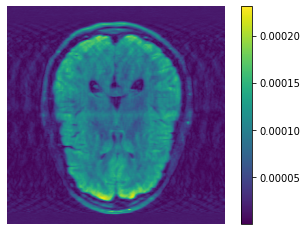

Text(0, 0.5, 'cost')

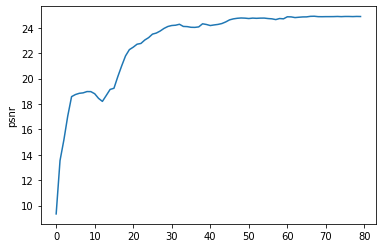

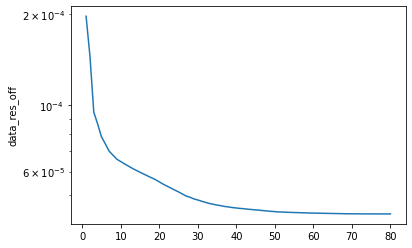

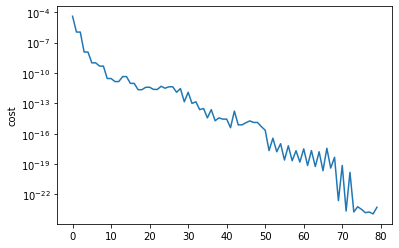

In [11]:
online_pb = OnlineReconstructor(line_fourier_op,
                                linear_op,
                                regularizer_op=IdentityProx(),
                                opt='rmsprop',
                                verbose=0)

metrics = create_cartesian_metrics(online_pb, real_img, final_mask, final_k)
line_kspace_gen = DataOnlyKspaceGenerator(final_k, mask_loc)

xf, costs, metrics_results = online_pb.reconstruct(line_kspace_gen,
                                                   cost_op_kwargs=cost_op_kwargs,
                                                   metrics=metrics,
                                                   metric_call_period=1,
                                                   eta=1e-3,
                                                   gamma=0.0,
                                                   )
implot(ssos(xf),colorbar=True)
plt.plot(metrics_results['psnr']['values'])
plt.ylabel('psnr')

plt.figure()
plt.semilogy(metrics_results['data_res_off']['index'],
             metrics_results['data_res_off']['values'])
plt.ylabel('data_res_off')
plt.figure()
plt.semilogy(costs)
plt.ylabel('cost')



100%|██████████| 20/20 [00:03<00:00,  5.61it/s]


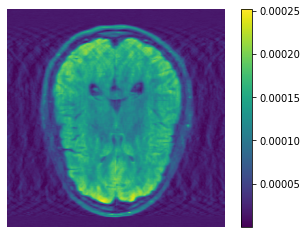

100%|██████████| 20/20 [00:03<00:00,  5.49it/s]


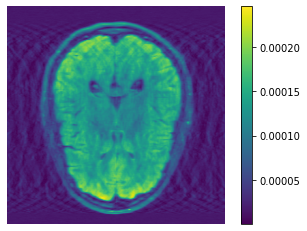

Text(0, 0.5, 'cost')

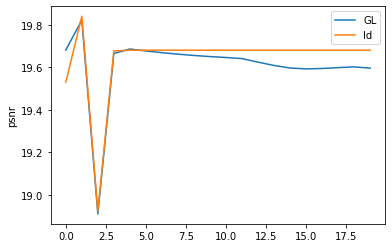

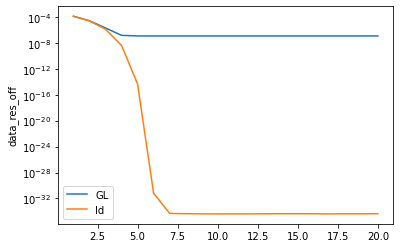

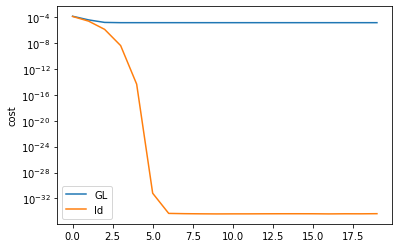

In [12]:
from online.generators.base import KspaceGenerator
from mri.operators import FFT

off_kspace_gen = KspaceGenerator(final_k, final_mask,max_iter=20)
K_DIM = off_kspace_gen.shape[-2:]
N_COILS = off_kspace_gen.shape[0] if full_k.ndim == 3 else 1

off_fourier_op = FFT(shape=K_DIM, mask=final_mask, n_coils=N_COILS, n_jobs=N_JOBS)

offline_pb = OnlineReconstructor(off_fourier_op,
                                linear_op,
#                               regularizer_op=GroupLASSO(weights = 1e-4),
                                regularizer_op=IdentityProx(),
                                opt='rmsprop',
                                verbose=0)

metrics = create_cartesian_metrics(online_pb, real_img, final_mask, final_k)

xf, costs, metrics_results = offline_pb.reconstruct(off_kspace_gen,
                                                   cost_op_kwargs=cost_op_kwargs,
                                                   metrics=metrics,
                                                   metric_call_period=1,
                                                   eta=0.001,
                                                   gamma=0.,
                                                   )
implot(ssos(xf),colorbar=True)



offline_pb = OnlineReconstructor(off_fourier_op,
                                linear_op,
                                 regularizer_op=GroupLASSO(weights = 5e-4),
#                                 regularizer_op=IdentityProx(),
                                opt='rmsprop',
                                verbose=0)

metrics = create_cartesian_metrics(online_pb, real_img, final_mask, final_k)

xf, reg_costs, reg_results = offline_pb.reconstruct(off_kspace_gen,
                                                   cost_op_kwargs=cost_op_kwargs,
                                                   metrics=metrics,
                                                   metric_call_period=1,
                                                   eta=0.001,
                                                   gamma=0.,
                                                   )
implot(ssos(xf),colorbar=True)

plt.plot(reg_results['psnr']['values'],label='GL')
plt.plot(metrics_results['psnr']['values'],label='Id')
plt.legend()

plt.ylabel('psnr')

plt.figure()
plt.semilogy(reg_results['data_res_off']['index'],
             reg_results['data_res_off']['values'],
            label='GL')
plt.legend()
plt.semilogy(metrics_results['data_res_off']['index'],
             metrics_results['data_res_off']['values'],
            label='Id')
plt.legend()

plt.ylabel('data_res_off')
plt.figure()
plt.semilogy(reg_costs,label='GL')
plt.semilogy(costs,label='Id')
plt.legend()
plt.ylabel('cost')



100%|██████████| 80/80 [00:12<00:00,  6.31it/s]


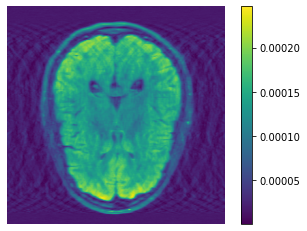

100%|██████████| 80/80 [00:12<00:00,  6.24it/s]


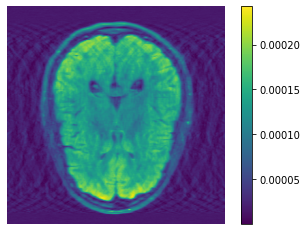

Text(0, 0.5, 'cost')

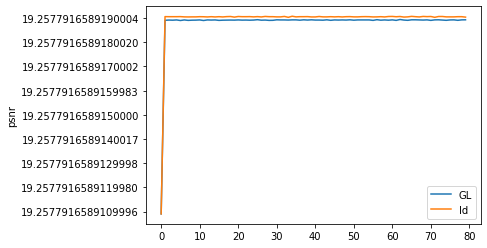

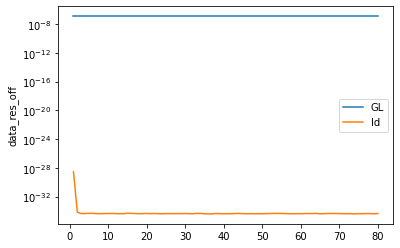

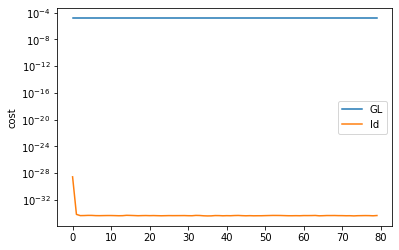

In [15]:
from online.generators.base import KspaceGenerator
from mri.operators import FFT

off_kspace_gen = KspaceGenerator(final_k, final_mask,max_iter=80)
K_DIM = off_kspace_gen.shape[-2:]
N_COILS = off_kspace_gen.shape[0] if full_k.ndim == 3 else 1

off_fourier_op = FFT(shape=K_DIM, mask=final_mask, n_coils=N_COILS, n_jobs=N_JOBS)

offline_pb = OnlineReconstructor(off_fourier_op,
                                linear_op,
#                                 regularizer_op=GroupLASSO(weights = 1e-4),
                                regularizer_op=IdentityProx(),
                                opt='vanilla',
                                verbose=0)

metrics = create_cartesian_metrics(online_pb, real_img, final_mask, final_k)

xf, costs, metrics_results = offline_pb.reconstruct(off_kspace_gen,
                                                   cost_op_kwargs=cost_op_kwargs,
                                                   metrics=metrics,
                                                   metric_call_period=1,
                                                   eta=1.,
                                                   )
implot(ssos(xf),colorbar=True)



offline_pb = OnlineReconstructor(off_fourier_op,
                                linear_op,
                                 regularizer_op=GroupLASSO(weights = 5e-4),
#                                 regularizer_op=IdentityProx(),
                                opt='vanilla',
                                verbose=0)

metrics = create_cartesian_metrics(online_pb, real_img, final_mask, final_k)

xf, reg_costs, reg_results = offline_pb.reconstruct(off_kspace_gen,
                                                   cost_op_kwargs=cost_op_kwargs,
                                                   metrics=metrics,
                                                   metric_call_period=1,
                                                   eta=1.,
                                                   )
implot(ssos(xf),colorbar=True)

plt.plot(reg_results['psnr']['values'],label='GL')
plt.plot(metrics_results['psnr']['values'],label='Id')
plt.legend()
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.ylabel('psnr')

plt.figure()
plt.semilogy(reg_results['data_res_off']['index'],
             reg_results['data_res_off']['values'],
            label='GL')
plt.legend()
plt.semilogy(metrics_results['data_res_off']['index'],
             metrics_results['data_res_off']['values'],
            label='Id')
plt.legend()

plt.ylabel('data_res_off')
plt.figure()
plt.semilogy(reg_costs,label='GL')
plt.semilogy(costs,label='Id')
plt.legend()
plt.ylabel('cost')

